# Прогнозирование отмены бронирования 

## Введение

Чтобы привлечь клиентов, сеть отелей «Как в гостях» добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, требуется разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

      
**Цель проекта:** разработать для сети отелей систему, которая с помощью модели машинного обучения предсказывает отказ клиента от брони.

**Данные:** 

  - Тренировочный набор данных с информацией о клиентах, заказах, номерах и т.д.
  
  - Тестовый набор данных с информацией о клиентах, заказах, номерах и т.д.
    
  
**План выполнения проекта:**

  - Загрузить и изучить данные;
  
  - Провести предобработку и исследовательский анализ данных;
  
  - Вычислить бизнес-метрику;
  
  - Разработать модель ML и оценить прибыль от внедрения:
    
    - Выбрать метрику для обучения.
    
    - Обучить разные модели и оцените их качество кросс-валидацией. 
    
    - Выбрать лучшую модель и проверьте её на тестовой выборке.   

    - Оценить прибыль, которую принесёт выбранная модель за год.
    
  
  - Сформулировать и оформить промежуточный и общий выводы и рекомендации бизнесу.

## Загрузка и изучение данных

In [1]:
# обновляем библиотеку scikit-learn
# !pip install scikit-learn==1.1.3 -U

In [2]:
# загружаем библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle 

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# настраиваем отображение 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [3]:
# читаем данные и приводим тип данных в столбце с годом к дате 
hotel_train = pd.read_csv('/datasets/hotel_train.csv', sep=",")

hotel_test = pd.read_csv('/datasets/hotel_test.csv', sep=",")   

In [4]:
# выводим инфо об обучающих данных
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [5]:
# читаем первые строки обучающих данных
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [6]:
# выводим инфо о тестовых данных 
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [7]:
# читаем первые строки тестовых данных
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


### Вывод по первому шагу

- Данне загружены и изучены:
  
   - Пропусков нет. 
   
   - В обоих датасетах одинаковое количество строк; 
   
   - Данные в нескольких столбцах имеют строковый тип.
 

## Предобработка и исследовательский анализ данных

### I.Предобработка

In [8]:
# смотрим уникальные названия в столбце с годом
print(hotel_train['arrival_date_year'].unique())
print(hotel_test['arrival_date_year'].unique())

[2015 2016]
[2017]


In [9]:
# смотрим уникальные названия в столбце с месяцем
print(hotel_train['arrival_date_month'].unique())
print(hotel_test['arrival_date_month'].unique())

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


In [10]:
# меняем название месяца на номер месяца в обучающем наборе
hotel_train['arrival_date_month'] = hotel_train[
    'arrival_date_month'
].replace(['January',
           'February',
           'March',
           'April',
           'May',
           'June',
           'July',
           'August',
           'September',
           'October',
           'November',
           'December' ],
          [1,2,3,4,5,6,7,8,9,10,11,12],
          regex=True)

# проверяем 
print(hotel_train['arrival_date_month'].unique())

[ 7  8  9 10 11 12  1  2  3  4  5  6]


In [11]:
# меняем название месяца на номер месяца в тестовом наборе
hotel_test['arrival_date_month'] = hotel_test[
    'arrival_date_month'
].replace(['January',
           'February', 
           'March',
           'April',
           'May',
           'June',
           'July',
           'August' ],
          [1,2,3,4,5,6,7,8],
          regex=True)

# проверяем 
print(hotel_test['arrival_date_month'].unique())

[1 2 3 4 5 6 7 8]


In [12]:
# удаляем лишний столбец в обучающем наборе
hotel_train.drop('id', axis=1, inplace=True)

# проверяем
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  int64  
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                            65229 non-null  object 
 12  country                         

In [13]:
# удаляем лишний столбец в тестовом наборе
hotel_test.drop('id', axis=1, inplace=True)

# проверяем
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32412 non-null  int64  
 1   lead_time                       32412 non-null  float64
 2   arrival_date_year               32412 non-null  int64  
 3   arrival_date_month              32412 non-null  int64  
 4   arrival_date_week_number        32412 non-null  int64  
 5   arrival_date_day_of_month       32412 non-null  int64  
 6   stays_in_weekend_nights         32412 non-null  int64  
 7   stays_in_week_nights            32412 non-null  int64  
 8   adults                          32412 non-null  float64
 9   children                        32412 non-null  float64
 10  babies                          32412 non-null  float64
 11  meal                            32412 non-null  object 
 12  country                         

In [14]:
# смотрим уникальные значения в столбцах с нечисловыми данными в обучающем наборе
columns = ['country', 'customer_type','distribution_channel', 'meal','reserved_room_type']
def values_unique(data):
    for column in columns:
        values = data[column].unique()
        print('Уникальные значения столбца:', column)
        print(values)
        print()
           
values_unique(hotel_train)

Уникальные значения столбца: country
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 'RWA' 'MNE']

Уникальные значения

In [15]:
# смотрим уникальные значения в столбцах с нечисловыми данными в тестовом наборе
values_unique(hotel_test)

Уникальные значения столбца: country
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'
 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'
 'MCO' 'MUS' 'SYR' 'TGO' 'IRQ' 'LKA' 'BIH' 'PRY' 'MRT' 'ABW' 'NCL' 'STP'
 'KIR' 'SDN' 'PRI' 'ATF' 'CMR' 'TJK' 'LBY' 'SLE' 'SLV' 'LAO' 'FRO']

Уникальные значения столбца: customer_type
['Transient' 'Transient-Party' 'Contract' 'Group'

In [16]:
# удаляем лишние пробелы в данных в обучающем наборе
columns = ['reserved_room_type','meal']
for column in columns:
    hotel_train[column] = hotel_train[column].str.strip()

    #проверяем
    print(hotel_train[column].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']
['BB' 'FB' 'HB' 'SC']


In [17]:
# удаляем лишние пробелы в данных в тестовом наборе
columns = ['reserved_room_type','meal']
for column in columns:
    hotel_test[column] = hotel_test[column].str.strip()

    #проверяем
    print(hotel_test[column].unique())

['A' 'E' 'G' 'D' 'F' 'C' 'B']
['BB' 'HB' 'SC' 'FB']


In [18]:
# проверяем данные о количестве ночей на наличие аномалий 
print(hotel_train['total_nights'].sum()-((hotel_train[
    'stays_in_week_nights']+ hotel_train['stays_in_weekend_nights']).sum()))

print(hotel_test['total_nights'].sum()-((hotel_test[
    'stays_in_week_nights']+ hotel_test['stays_in_weekend_nights']).sum()))

0
0


In [19]:
# ищем аномалии в данных о постояльцах в обучающем наборе
print(hotel_train['adults'].unique())
print(hotel_train['children'].unique())
print(hotel_train['babies'].unique())

[1. 2. 3. 4. 0.]
[0. 1. 2. 3.]
[ 0.  1.  2. 10.  9.]


In [20]:
# ищем аномалии в данных о постояльцах в тестовом наборе
print(hotel_test['adults'].unique())
print(hotel_test['children'].unique())
print(hotel_test['babies'].unique())

[2. 1. 3. 4. 0.]
[0. 2. 1. 3.]
[0. 1. 2.]


In [21]:
# считаем количество аномальных строчек о постояльцах 
print(hotel_train.loc[(hotel_train[
    'adults'] == 0) & (hotel_train['children'] == 0) & (hotel_train['babies'] == 0), 'adults'].count())

print(hotel_test.loc[(hotel_test[
    'adults'] == 0) & (hotel_test['children'] == 0) & (hotel_test['babies'] == 0), 'adults'].count())

15
7


In [22]:
# ищем самое часто встречающееся значение в сроках 'adults' в обучающем наборе
hotel_train['adults'].value_counts()

2.0    48980
1.0    13212
3.0     2858
0.0      166
4.0       13
Name: adults, dtype: int64

In [23]:
# заменяем аномальные значения в строках 'adults' на самое частое значение в обучающем наборе
hotel_train.loc[(hotel_train[
    'adults'] == 0) & (hotel_train['children'] == 0) & (hotel_train['babies'] == 0), 'adults'] = 2

# заменяем аномальные значения в строках 'adults' в тестовом наборе на самое частое значение в тестовом наборе
hotel_test.loc[(hotel_test[
    'adults'] == 0) & (hotel_test['children'] == 0) & (hotel_test['babies'] == 0), 'adults'] = 2

# проверяем
print(hotel_train.loc[(hotel_train[
    'adults'] == 0) & (hotel_train['children'] == 0) & (hotel_train['babies'] == 0), 'adults'].count())
# проверяем
hotel_test.loc[(hotel_test[
    'adults'] == 0) & (hotel_test['children'] == 0) & (hotel_test['babies'] == 0), 'adults'].count()

0


0

In [24]:
# считаем строки с аномальным числом младенцев в обучающем наборе
hotel_train.loc[hotel_train['babies']>8, 'babies'].count()

2

In [25]:
# смотрим уникальные значение в строках 'babies' в обучающем наборе
hotel_train['babies'].value_counts()

0.0     64777
1.0       447
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

In [26]:
# заменяем аномальные значения в строках 'babies' в обучающем наборе
hotel_train.loc[hotel_train['babies']>8,'babies']=1
# проверяем
hotel_train['babies'].unique()

array([0., 1., 2.])

In [27]:
# смотрим коды стран в обучающем наборе 
hotel_train['country'].sort_values().unique()

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS',
       'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP',
       'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB',
       'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT',
       'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC',
       'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE',
       'MOZ', 'MUS', 'MWI', 'MYS', 'NAM', 'NGA', 'NIC', 'NLD', 'NOR',
       'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRI',
       'PRT', 'PRY', 'PYF', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN',
       'SGP', 'SLV', 

In [28]:
# смотрим коды стран в тестовом наборе
hotel_test['country'].sort_values().unique()

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF',
       'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BHS',
       'BIH', 'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK',
       'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI',
       'FRA', 'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM',
       'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ',
       'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN',
       'KIR', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LIE', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MLT',
       'MNE', 'MOZ', 'MRT', 'MUS', 'MYS', 'MYT', 'NCL', 'NGA', 'NLD',
       'NOR', 'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI',
       'PRT', 'PRY', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SEN', 'SGP',
       'SLE', 'SLV', 'SRB', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SYC',
       'SYR', 'TGO', 

In [29]:
# меняем аномальные значения в обучающем наборе
hotel_train.loc[hotel_train['country'] == 'CN', 'country'] = 'CHN'
hotel_train.loc[hotel_train['country'] == 'TMP', 'country'] = 'TLS'                                 
# проверяем
hotel_train['country'].sort_values().unique()

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS',
       'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE',
       'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST',
       'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP',
       'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY',
       'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN',
       'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR',
       'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ',
       'MUS', 'MWI', 'MYS', 'NAM', 'NGA', 'NIC', 'NLD', 'NOR', 'NZL',
       'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRI', 'PRT',
       'PRY', 'PYF', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN', 'SGP',
       'SLV', 'SMR',

In [30]:
# меняем аномальные значения в тестовом наборе
hotel_test.loc[hotel_test['country'] == 'CN', 'country'] = 'CHN'                               
# проверяем
hotel_test['country'].sort_values().unique()

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF',
       'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BHS',
       'BIH', 'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM',
       'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA',
       'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM', 'HKG',
       'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL',
       'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KIR',
       'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LIE', 'LKA', 'LTU', 'LUX',
       'LVA', 'MAC', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MLT', 'MNE',
       'MOZ', 'MRT', 'MUS', 'MYS', 'MYT', 'NCL', 'NGA', 'NLD', 'NOR',
       'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRT',
       'PRY', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE',
       'SLV', 'SRB', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SYC', 'SYR',
       'TGO', 'THA',

In [31]:
# создаем датафрейм со словарем кодов стран и соответствующих регионов 
df = {'alfa3': ['ABW','AGO','ALB','AND','ARE','ARG','ARM','ATA','AUS','AUT',
'AZE','BDI','BEL','BEN','BFA','BGD','BGR','BHR','BIH','BLR','BOL',
'BRA','BRB','BWA','CHE','CHL','CHN','CIV','CMR','COL','CPV',
'CRI','CUB','CYM','CYP','CZE','DEU','DMA','DNK','DOM','DZA',
'ECU','EGY','ESP','EST','ETH','FIN','FRA','GAB','GBR','GEO',
'GGY','GIB','GLP','GNB','GRC','GUY','HKG','HND','HRV','HUN',
'IDN','IMN','IND','IRL','IRN','IRQ','ISL','ISR','ITA','JAM','JEY','JOR',
'JPN','KAZ','KEN','KHM','KNA','KOR','KWT','LBN','LBY','LCA','LIE',
'LKA','LTU','LUX','LVA','MAC','MAR','MCO','MDV','MEX','MKD','MLI',
'MLT','MMR','MNE','MOZ','MUS','MWI','MYS','NAM','NGA','NIC',
'NLD','NOR','NZL','OMN','PAK','PAN','PER','PHL','PLW','POL',
'PRI','PRT','PRY','PYF','QAT','ROU','RUS','RWA','SAU','SEN','SGP',
'SLV','SMR','SRB','STP','SUR','SVK','SVN','SWE','SYC','SYR',
'THA','TJK','TLS','TUN','TUR','TWN','TZA','UGA','UKR','URY','USA',
'UZB','VEN','VGB','VNM','ZAF','ZMB','ZWE','ASM','ATF','BHS',
'CAF','FJI','FRO','GHA','GTM','KIR','LAO','MDG','MRT','MYT','NCL',
'NPL','SDN','SLE','TGO','UMI'
],
      'region': ['Americas','Africa','Europe','Europe','Asia','Americas','Asia','Antarctica',
'Oceania','Europe','Asia','Africa','Europe','Africa','Africa','Asia','Europe',
'Asia','Europe','Europe','Americas','Americas','Americas','Africa','Europe',
'Americas','Asia','Africa','Africa','Americas','Africa','Americas','Americas',
'Americas','Europe','Europe','Europe','Americas','Europe','Americas','Africa',
'Americas','Africa','Europe','Europe','Africa','Europe','Europe','Africa','Europe',
'Asia','Europe','Europe','Americas','Africa','Europe','Americas','Asia',
'Americas','Europe','Europe','Asia','Europe','Asia','Europe','Asia','Asia','Europe',
'Asia','Europe','Americas','Europe','Asia','Asia','Asia','Africa','Asia','Americas',
'Asia','Asia','Asia','Africa','Americas','Europe','Asia','Europe','Europe','Europe',
'Asia','Africa','Europe','Asia','Americas','Americas','Africa','Europe','Asia',
'Europe','Africa','Africa','Africa','Asia','Africa','Africa','Americas','Europe',
'Europe','Oceania','Asia','Asia','Americas','Americas','Asia','Oceania','Europe',
'Americas','Europe','Americas','Oceania','Asia','Europe','Europe','Africa',
'Asia','Africa','Asia','Americas','Europe','Europe','Africa','Americas','Europe',
'Europe','Europe','Africa','Asia','Asia','Asia','Asia','Africa','Asia','Asia','Africa',
'Africa','Europe','Americas','Americas','Asia','Americas','Americas','Asia',
'Africa','Africa','Africa','Oceania','Americas','Americas','Africa','Oceania','Europe',
'Africa','Americas','Asia','Asia','Africa','Africa','Africa','Europe','Asia','Africa',
'Africa','Africa','Americas']}

# создаем датафрейм
country_dict= pd.DataFrame(data=df)

# проверяем
country_dict.head()

,alfa3,region
0,ABW,Americas
1,AGO,Africa
2,ALB,Europe
3,AND,Europe
4,ARE,Asia


In [32]:
# добавляем столбец с регионом в обучающий набор
hotel_train=pd.merge(hotel_train, 
                     country_dict[[
                         'alfa3',
                         'region']],
                     left_on='country', 
                     right_on='alfa3', 
                     how ='left')

# удаляем лишние столбцы
hotel_train.drop(['country','alfa3'], axis=1, inplace=True)

# проверяем
print(hotel_train['region'].sort_values().unique())
print()
hotel_train.info()

['Africa' 'Americas' 'Antarctica' 'Asia' 'Europe' 'Oceania']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  int64  
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                           

In [33]:
# добавляем столбец с регионом в тестовый набор
hotel_test=pd.merge(hotel_test, 
                     country_dict[[
                         'alfa3',
                         'region']],
                     left_on='country', 
                     right_on='alfa3', 
                     how ='left')

# удаляем лишние столбцы
hotel_test.drop(['country','alfa3'], axis=1, inplace=True)

# проверяем
print(hotel_test['region'].sort_values().unique())
print()
hotel_test.info()

['Africa' 'Americas' 'Antarctica' 'Asia' 'Europe' 'Oceania']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32412 entries, 0 to 32411
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32412 non-null  int64  
 1   lead_time                       32412 non-null  float64
 2   arrival_date_year               32412 non-null  int64  
 3   arrival_date_month              32412 non-null  int64  
 4   arrival_date_week_number        32412 non-null  int64  
 5   arrival_date_day_of_month       32412 non-null  int64  
 6   stays_in_weekend_nights         32412 non-null  int64  
 7   stays_in_week_nights            32412 non-null  int64  
 8   adults                          32412 non-null  float64
 9   children                        32412 non-null  float64
 10  babies                          32412 non-null  float64
 11  meal                           

### Вывод по второму шагу: предобработка.

 - Очистили данные от аномалий, лишних столбцов, закодировали месяцы и сгруппировали страны по регионам.

### II.Исследовательский анализ

'Распределение числовых значений в обучающем наборе данных'

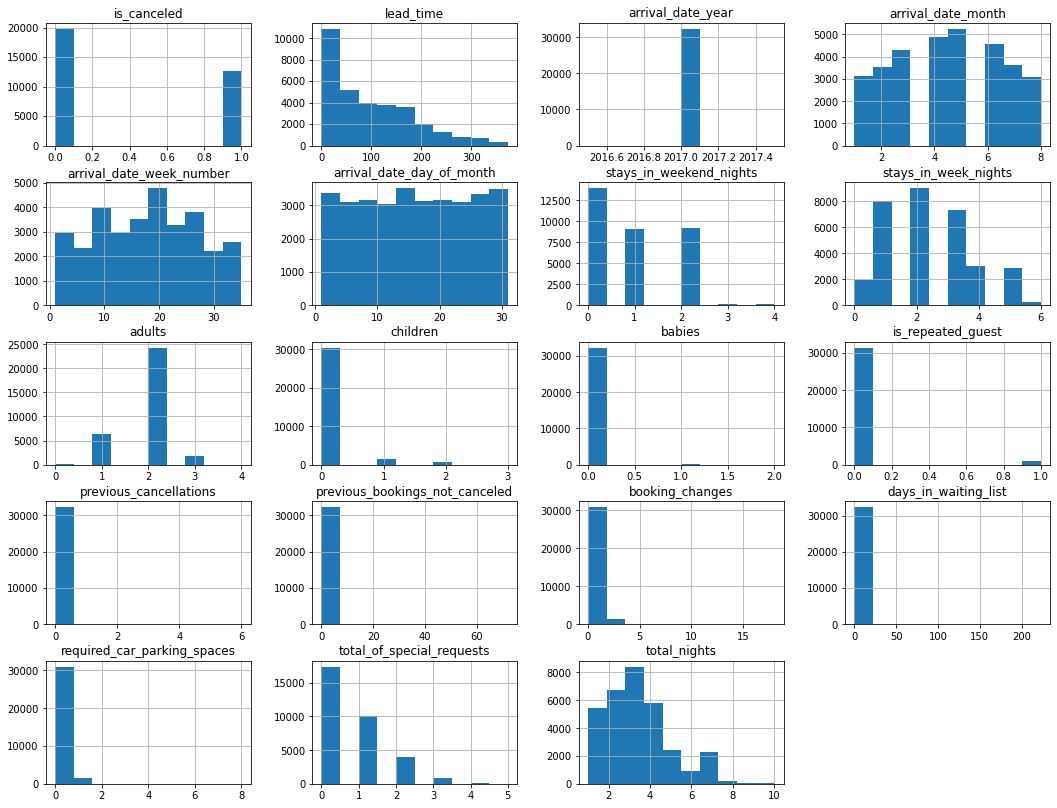

In [34]:
# смотрим столбцы с числовыми данными обучающего набора на графиках
display('Распределение числовых значений в обучающем наборе данных')
hotel_test.hist(bins=10,figsize=[18,14]);

'Распределение числовых значений в тестовом наборе данных'

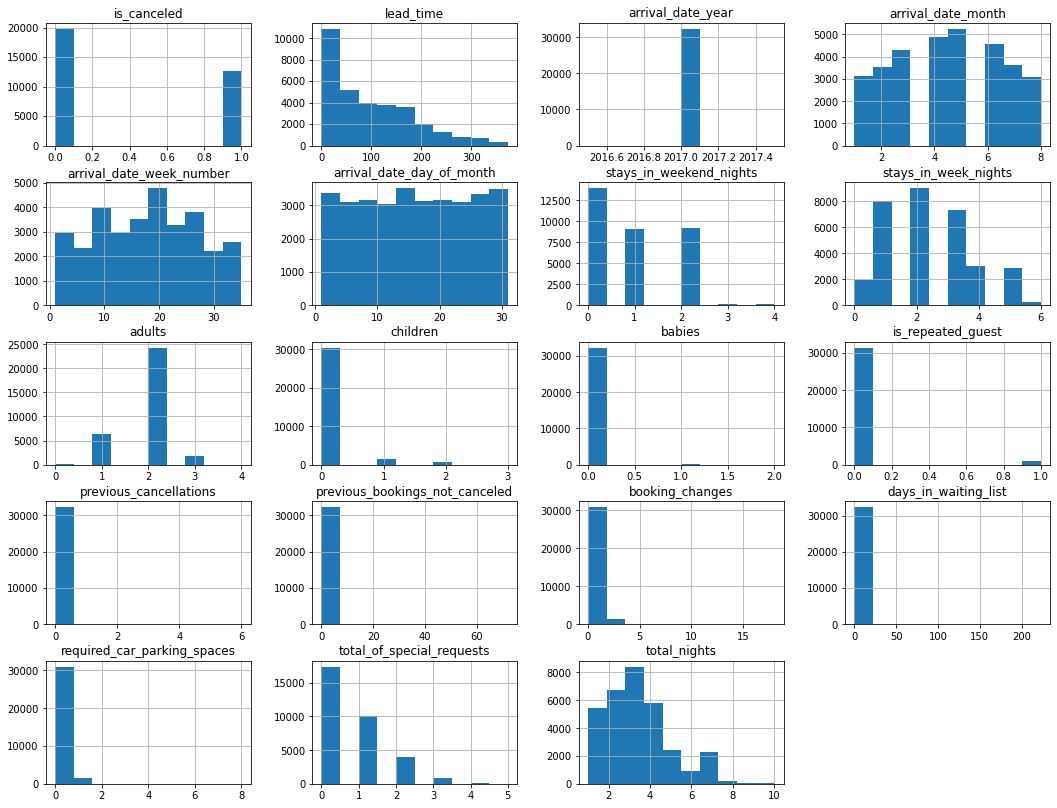

In [35]:
# смотрим столбцы с числовыми данными тестового набора на графиках
display('Распределение числовых значений в тестовом наборе данных')
hotel_test.hist(bins=10,figsize=[18,14]);

In [36]:
# создаем функцию для построения диаграмм разброса для ключевых признаков 
def boxplotly(data, xlabel, ylabel, title):
    
    plt.figure(figsize=(18, 5))    
    sns.boxplot(data=data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.title(title)
    plt.show()   

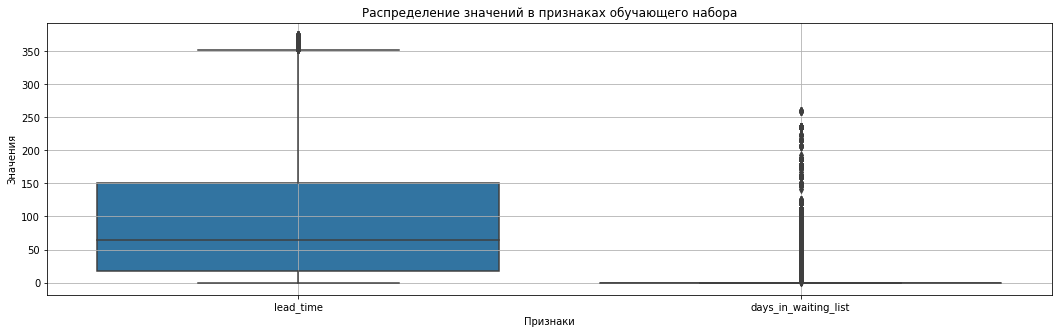

In [37]:
columns = (['lead_time','days_in_waiting_list'])
boxplotly(hotel_train[columns], 'Признаки', 'Значения', 'Распределение значений в признаках обучающего набора')

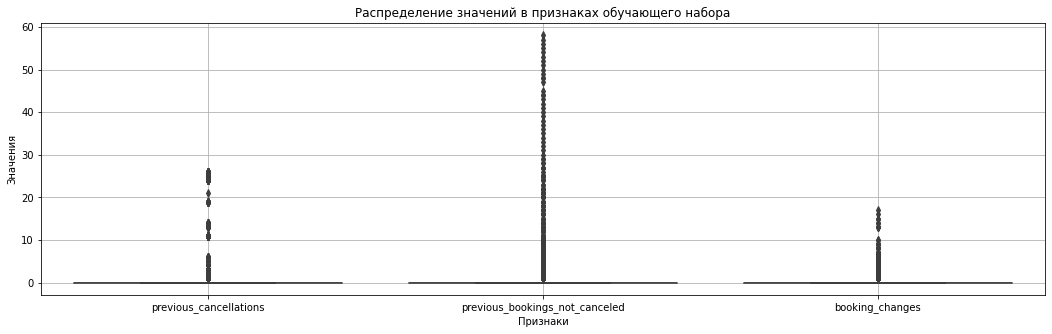

In [38]:
columns = (['previous_cancellations','previous_bookings_not_canceled','booking_changes'])
boxplotly(hotel_train[columns], 'Признаки', 'Значения', 'Распределение значений в признаках обучающего набора')

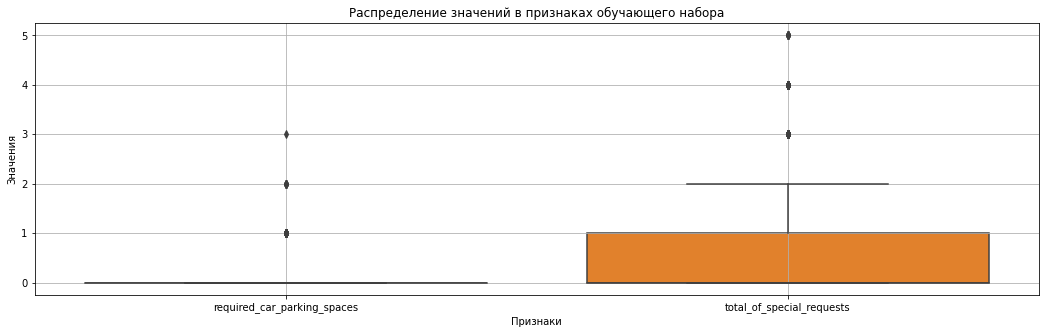

In [39]:
columns = (['required_car_parking_spaces','total_of_special_requests'])
boxplotly(hotel_train[columns], 'Признаки', 'Значения', 'Распределение значений в признаках обучающего набора')

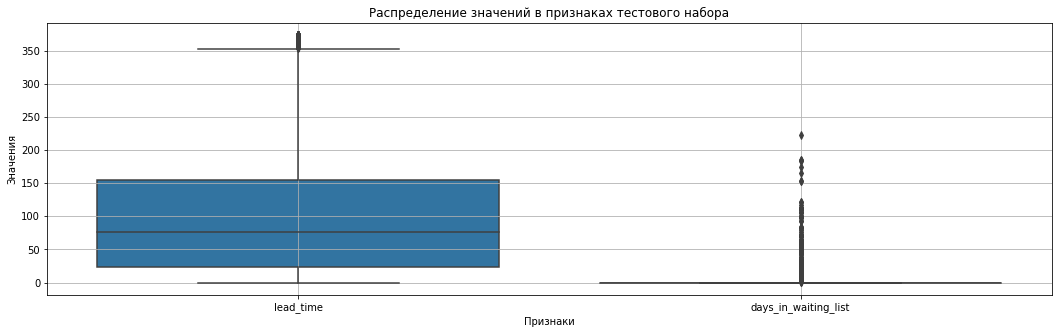

In [40]:
columns = (['lead_time','days_in_waiting_list'])
boxplotly(hotel_test[columns], 'Признаки', 'Значения', 'Распределение значений в признаках тестового набора')

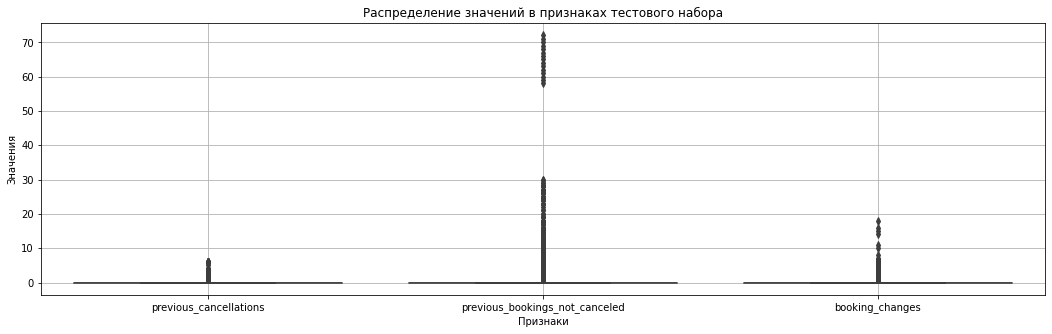

In [41]:
columns = (['previous_cancellations','previous_bookings_not_canceled','booking_changes'])
boxplotly(hotel_test[columns], 'Признаки', 'Значения', 'Распределение значений в признаках тестового набора')

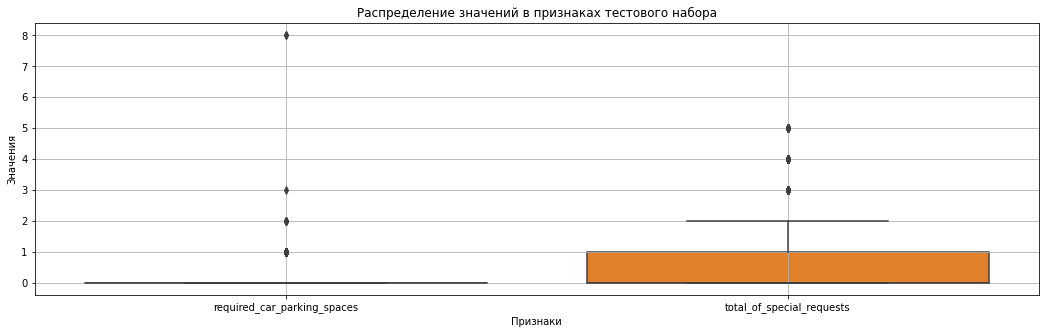

In [42]:
columns = (['required_car_parking_spaces','total_of_special_requests'])
boxplotly(hotel_test[columns], 'Признаки', 'Значения', 'Распределение значений в признаках тестового набора')

In [43]:
# смотрим распределение уникальных значений в столбцах с нечисловыми данными в обучающем наборе
columns = ['customer_type','distribution_channel', 'meal','reserved_room_type']
def values_counts_data(data):
    for column in columns:
        values = data[column].value_counts(normalize=True)
        print('Уникальные значения столбца:', column)
        print(values)
        print()
           
values_counts_data(hotel_train)

Уникальные значения столбца: customer_type
Transient          0.697435
Transient-Party    0.256067
Contract           0.042098
Group              0.004400
Name: customer_type, dtype: float64

Уникальные значения столбца: distribution_channel
TA/TO        0.834813
Direct       0.105061
Corporate    0.058609
GDS          0.001518
Name: distribution_channel, dtype: float64

Уникальные значения столбца: meal
BB    0.792546
HB    0.111791
SC    0.088749
FB    0.006914
Name: meal, dtype: float64

Уникальные значения столбца: reserved_room_type
A    0.774211
D    0.143908
E    0.037529
F    0.018596
B    0.013184
G    0.009076
C    0.003495
Name: reserved_room_type, dtype: float64



In [44]:
# смотрим распределение уникальных значений в столбцах с нечисловыми данными в тестовом наборе
values_counts_data(hotel_test)

Уникальные значения столбца: customer_type
Transient          0.847248
Transient-Party    0.136585
Contract           0.011076
Group              0.005091
Name: customer_type, dtype: float64

Уникальные значения столбца: distribution_channel
TA/TO        0.835586
Direct       0.112366
Corporate    0.049426
GDS          0.002622
Name: distribution_channel, dtype: float64

Уникальные значения столбца: meal
BB    0.761570
SC    0.163304
HB    0.074016
FB    0.001111
Name: meal, dtype: float64

Уникальные значения столбца: reserved_room_type
A    0.724145
D    0.188912
E    0.050722
F    0.015519
G    0.008577
C    0.006201
B    0.005924
Name: reserved_room_type, dtype: float64



In [45]:
# смотрим основные статистики числовых данных обучающего набора 
hotel_train.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,0.368609,96.337917,2015.719021,7.450367,31.339772,15.847813,0.825185,2.224793,1.837036,0.074890,0.006975,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,0.482431,96.127545,0.449481,3.099168,13.464024,8.748182,0.853477,1.354992,0.479443,0.334243,0.083779,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,2015.000000,5.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,64.000000,2016.000000,8.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,151.000000,2016.000000,10.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,12.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,2.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [46]:
# смотрим основные статистики числовых данных тестовгого набора
hotel_test.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,0.388467,97.587869,2017.0,4.520517,17.804054,15.656948,0.867888,2.34009,1.859034,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,0.487409,86.507146,0.0,2.106139,9.177384,8.766429,0.853394,1.37517,0.488583,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,0.000000,0.000000,2017.0,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,23.000000,2017.0,3.000000,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,76.000000,2017.0,5.000000,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,155.000000,2017.0,6.000000,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,373.000000,2017.0,8.000000,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


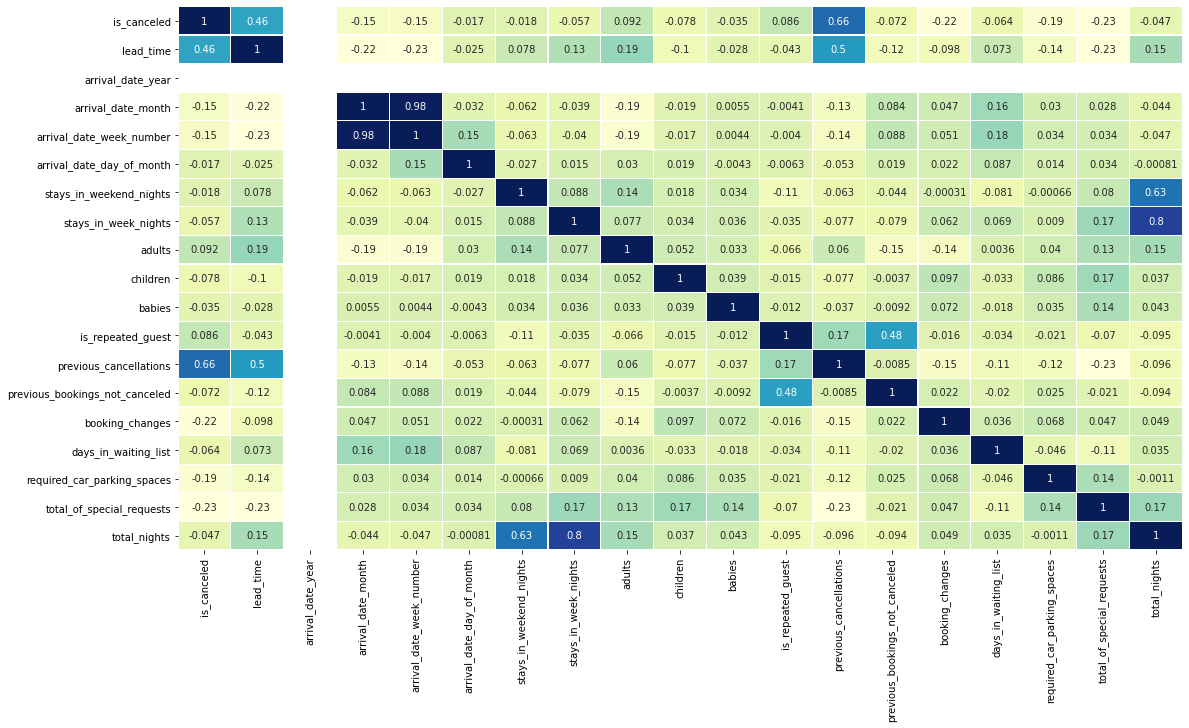

In [47]:
# строим тепловую диаграмму числовых признаков за 2015 год 
hotel_train_2015 = hotel_train[hotel_train['arrival_date_year']==2015]
plt.figure(figsize=(18, 10))
sns.heatmap(hotel_train_2015.corr(method='spearman'), 
            annot=True, 
            cmap='YlGnBu', 
            cbar=False, 
            robust=True, linewidths=.2)
plt.show()

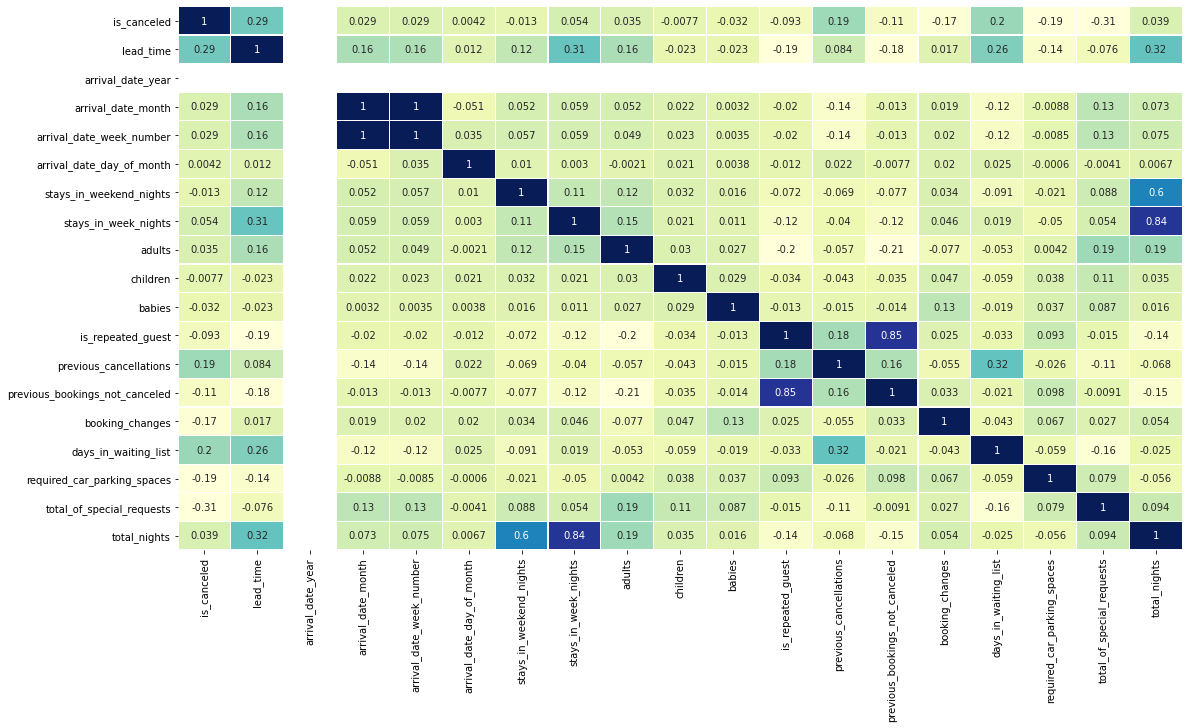

In [48]:
# строим тепловую диаграмму числовых признаков за 2016 год 
hotel_train_2016 = hotel_train.loc[hotel_train['arrival_date_year']==2016]
plt.figure(figsize=(18, 10))
sns.heatmap(hotel_train_2016.corr(method='spearman'), 
            annot=True, 
            cmap='YlGnBu', 
            cbar=False, 
            robust=True, linewidths=.2)
plt.show()

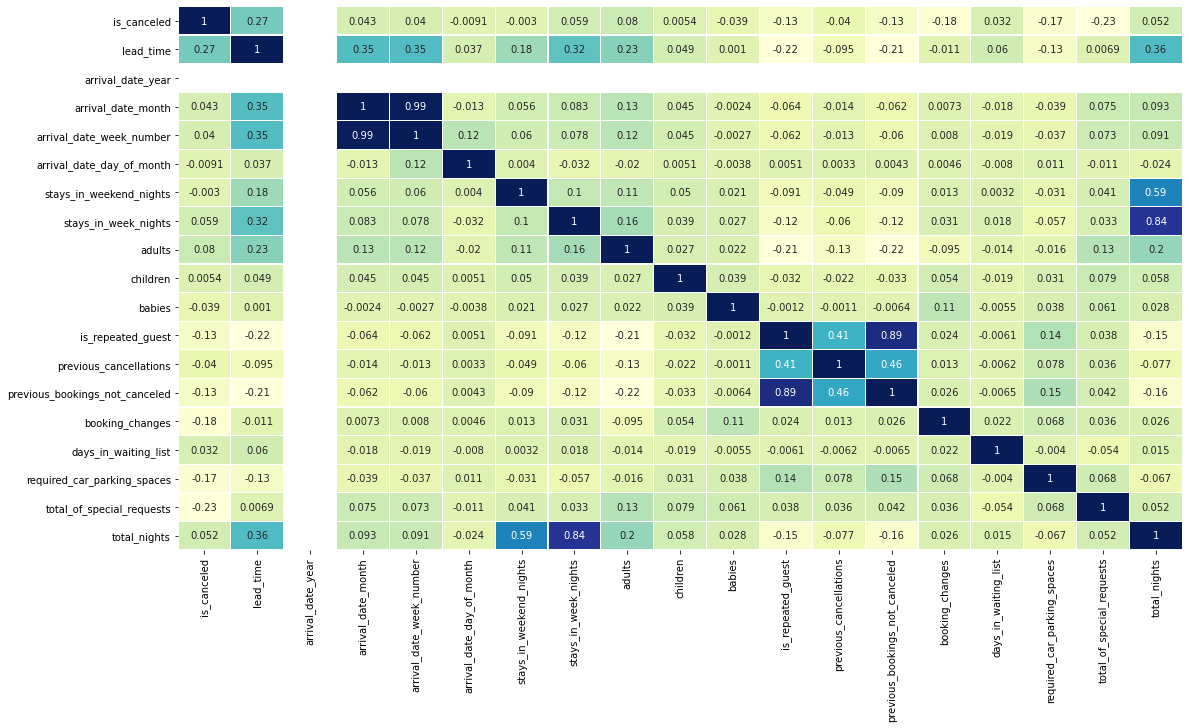

In [49]:
# строим тепловую диаграмму числовых признаков за 2017 год 
plt.figure(figsize=(18, 10))
sns.heatmap(hotel_test.corr(method='spearman'), 
            annot=True, 
            cmap='YlGnBu', 
            cbar=False, 
            robust=True, linewidths=.2)
plt.show()

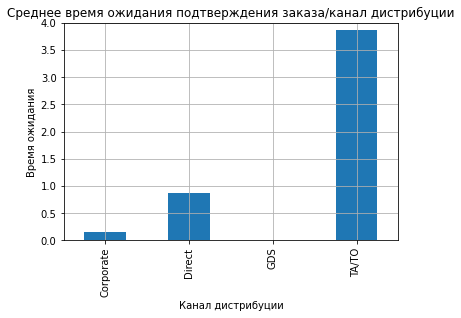

In [50]:
# строим график среднего ожидания подтверждения заказа по каналам дистрибуции
(hotel_train.pivot_table(index='distribution_channel', 
                 values='days_in_waiting_list',
                 aggfunc='mean'
                ).plot(
        kind='bar',        
        xlim=(0,27), 
        ylim=(0,4), 
        grid=True,
        legend=False))

plt.xlabel('Канал дистрибуции')
plt.ylabel('Время ожидания')
plt.title('Среднее время ожидания подтверждения заказа/канал дистрибуции')
plt.show()

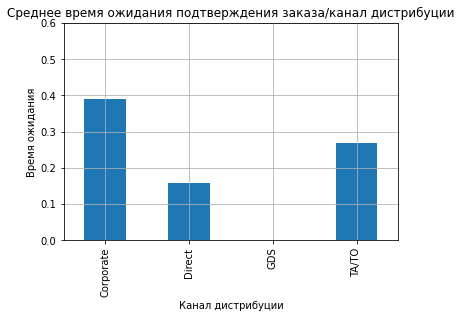

In [51]:
# строим график среднего ожидания подтверждения заказа по каналам дистрибуции
(hotel_test.pivot_table(index='distribution_channel', 
                 values='days_in_waiting_list',
                 aggfunc='mean'
                ).plot(
        kind='bar',        
        xlim=(0,27), 
        ylim=(0,0.6), 
        grid=True,
        legend=False))

plt.xlabel('Канал дистрибуции')
plt.ylabel('Время ожидания')
plt.title('Среднее время ожидания подтверждения заказа/канал дистрибуции')
plt.show()

In [52]:
# создаем функцию для построения графиков зависимости 
# между количеством отмененных заказов и количественными параметрами  2015-2016г
def plotly_num(data1, data2, data3, values, ylim, ylabel, title1, title2, title3):
    (
    data1
    .pivot_table(index='is_canceled', 
                 values=values                 
                ).plot(
        kind='bar',
        xlim=(0,27), 
        ylim=(ylim), 
        grid=True,
        legend=False))

    plt.xlabel('Отмененные заказы')
    plt.ylabel(ylabel)
    plt.title(title1)
    plt.show()

    (
    data2
    .pivot_table(index='is_canceled', 
                 values=values                 
                ).plot(
        kind='bar',
        xlim=(0,27), 
        ylim=(ylim), 
        grid=True,
        legend=False))

    plt.xlabel('Отмененные заказы')
    plt.ylabel(ylabel)
    plt.title(title2)
    plt.show()
    
    (
    data3
    .pivot_table(index='is_canceled', 
                 values=values                 
                ).plot(
        kind='bar',
        xlim=(0,27), 
        ylim=(ylim), 
        grid=True,
        legend=False))

    plt.xlabel('Отмененные заказы')
    plt.ylabel(ylabel)
    plt.title(title3)
    plt.show()

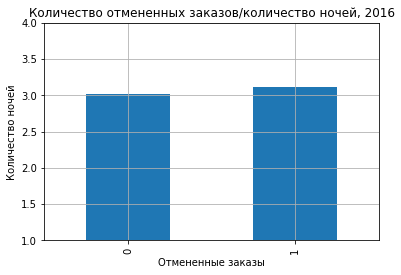

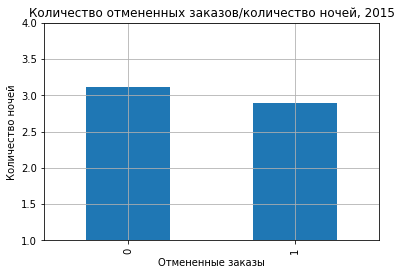

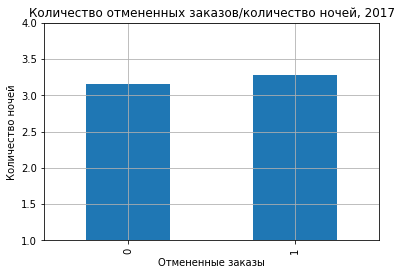

In [53]:
# строим гистограмму количества отмененных заказов и среднего количества ночей
plotly_num(hotel_train_2016,
       hotel_train_2015,
       hotel_test,    
       'total_nights',(1,4),
       'Количество ночей', 
       'Количество отмененных заказов/количество ночей, 2016', 
       'Количество отмененных заказов/количество ночей, 2015',
       'Количество отмененных заказов/количество ночей, 2017')

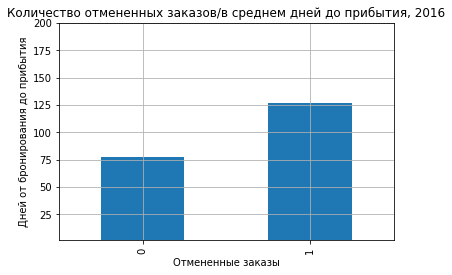

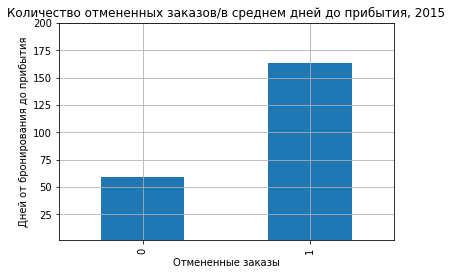

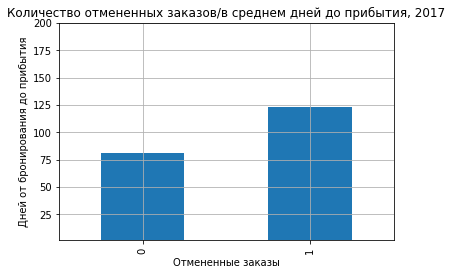

In [54]:
# строим гистограмму количества отмененных заказов и 
# среднего количества дней между датой бронирования и прибытия
plotly_num(hotel_train_2016,
       hotel_train_2015,
       hotel_test,    
       'lead_time',(1,200),
       'Дней от бронирования до прибытия', 
       'Количество отмененных заказов/в среднем дней до прибытия, 2016', 
       'Количество отмененных заказов/в среднем дней до прибытия, 2015',
       'Количество отмененных заказов/в среднем дней до прибытия, 2017')

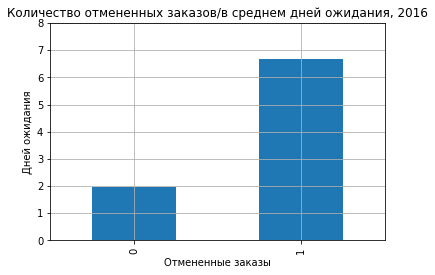

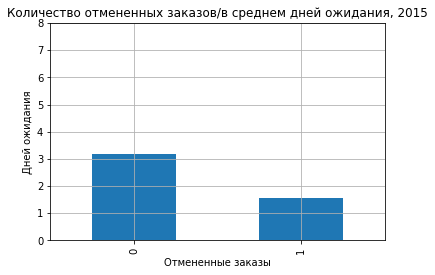

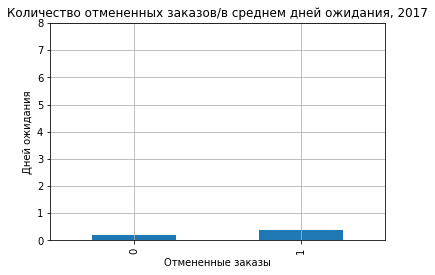

In [55]:
# строим гистограмму количества отмененных заказов и среднего количества дней ожидания
plotly_num(hotel_train_2016,
       hotel_train_2015,
       hotel_test,    
       'days_in_waiting_list',(0,8),
       'Дней ожидания', 
       'Количество отмененных заказов/в среднем дней ожидания, 2016', 
       'Количество отмененных заказов/в среднем дней ожидания, 2015',
       'Количество отмененных заказов/в среднем дней ожидания, 2017')

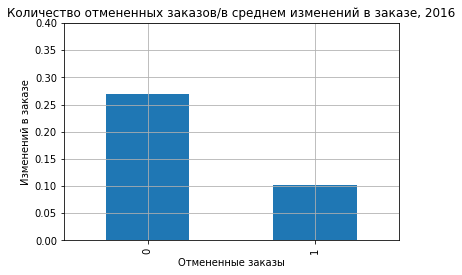

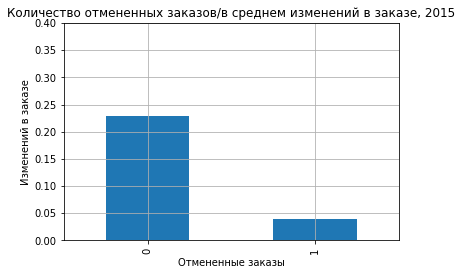

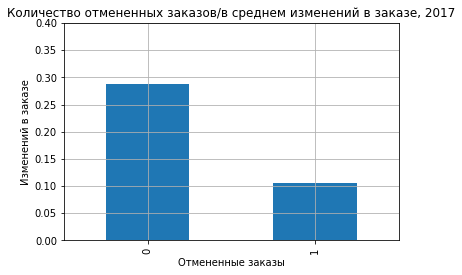

In [56]:
# строим гистограмму количества отмененных заказов и среднего количества изменений в заказе
plotly_num(hotel_train_2016,
       hotel_train_2015,
       hotel_test,    
       'booking_changes',(0,0.4),
       'Изменений в заказе', 
       'Количество отмененных заказов/в среднем изменений в заказе, 2016', 
       'Количество отмененных заказов/в среднем изменений в заказе, 2015',
       'Количество отмененных заказов/в среднем изменений в заказе, 2017')

### Вывод по второму шагу: исследовательский анализ 

  - Данные, в основном дискретные, распределены неравномерно, с многочисленными выбросами и провалами. 


  - Во многих столбцах превалирует нулевое значение.


  - Гости, в основной своей массе, путешествуют без детей, вдвоем, транзитом, во второй половине года, больше предпочитая селиться по вторникам, на две-три ночи, в номера класса "А", с включенным завтраком. 


  - Также, большинство будущих постояльцев предпочитают не бронировать номер заранее, пользуются агентствами и туроператорами.


  - Обращают на себя внимание слишком высокие значения lead_time (количество дней между датой бронирования и датой прибытия), достигающие 374. Данный показатель сильно коррелирует с previous_cancellation (количество предварительно отменных заказов) и еще сильнее - с целевой переменной (is_canceled).  


  - Также, прослеживается слабая, но заметная корреляция (особенно в 2015 году) days_in_waiting_list (время ожидания подтверждения заказа) с booking_changes (количество изменений в заказе),  что объяснимо: чем выше время ожидания, тем, вероятно,  больше изменений. Что напрямую сказывается на значении целевой переменной (is_canceled). Важно, что показатель времени ожидания выше у клиентов турагентств и туроператоров. Забегая вперед, скажем, что по количеству отмененных заказов лидируют они же. 
  
  
  - Наблюдается интересная динамика снижения корреляции целевой переменной (is_canceled) и previous_cancellation (количество предварительно отменных заказов) год от года: от сильной (0.66) в 2015 году, до едва заметной (-0.04) в 2017. 
  
  
  - Из особенностей следует отметить выбросы в столбце с переменной days_in_waiting_list: при среднем на уровне - 3.5, максимальное значение  - 259 (2015-2016гг).
  
  
  - Наибольшую корреляцию (как отрицательную, так и положительную) с целевой переменной (is_canceled) показывают: lead_time(0.27), total_of_special_requests(-0.23), booking_changes(-0.18), required_car_parking_spaces(-0.17),  is_repeated_guest(-0.13) (2017г). 
 

## Формулировка ML-задачи на основе бизнес-задачи

In [57]:
# создаем таблицу для расчета прибыли за 2015-2016гг
hotel_train_profit = hotel_train[[
    'arrival_date_year',
    'is_canceled',
    'arrival_date_month',
    'reserved_room_type',
    'total_nights']]

# проверяем
hotel_train_profit.head()

,arrival_date_year,is_canceled,arrival_date_month,reserved_room_type,total_nights
0,2015,0,7,A,1
1,2015,0,7,A,2
2,2015,0,7,C,2
3,2015,0,7,C,2
4,2015,1,7,A,3


In [58]:
# добавляем столбец со стоимостью номера (price)
# создаем функцию, возвращающую стоимость в зависимости от типа номера
def categorize_price(row):
        
    if 'A' in row:
        return 1000
    elif 'B' in row: 
        return 800
    elif 'C' in row:
        return 600
    elif 'D' in row:
        return 550
    elif 'E' in row:
        return 500
    elif 'F' in row:
        return 450
    elif 'G' in row:
        return 350

# и создаем в hotel_train_profit столбец price с результатами работы функции
hotel_train_profit['price'] = hotel_train_profit['reserved_room_type'].apply(categorize_price)

In [59]:
# добавляем столбец со стоимостью уборки (clean)
# создаем функцию, возвращающую стоимость уборки в зависимости от типа номера

def categorize_clean(row):
    if 'A' in row:
        return 400
    elif 'B' in row or 'C' in row: 
        return 350
    else:
        return 150

# и создаем в hotel_train_profit столбец price с результатами работы функции
hotel_train_profit['clean'] = hotel_train_profit['reserved_room_type'].apply(categorize_clean)

In [60]:
# добавляем столбец с сезонным дискаунтом
def categorize_discount(row):
    spring_automn = (3,4,5,9,10,11)
    summer = (6,7,8)
    winter = (1,2,12)
    
    if row in spring_automn:
        return 1.2
    elif row in summer: 
        return 1.4
    else:
        return 1

# и создаем в hotel_train_profit столбец price с результатами работы функции
hotel_train_profit['discount'] = hotel_train_profit['arrival_date_month'].apply(categorize_discount)

In [61]:
# добавляем столбец с убытком в случае отказа от бронирования 
hotel_train_profit['lost_cancel'] = (
    hotel_train_profit['price']+hotel_train_profit['clean'])*hotel_train_profit['discount']

In [62]:
# добавляем столбец с депозитом
hotel_train_profit['deposit'] = hotel_train_profit['lost_cancel']*0.8

# проверяем
hotel_train_profit.head(10) 

,arrival_date_year,is_canceled,arrival_date_month,reserved_room_type,total_nights,price,clean,discount,lost_cancel,deposit
0,2015,0,7,A,1,1000,400,1.4,1960.0,1568.0
1,2015,0,7,A,2,1000,400,1.4,1960.0,1568.0
2,2015,0,7,C,2,600,350,1.4,1330.0,1064.0
3,2015,0,7,C,2,600,350,1.4,1330.0,1064.0
4,2015,1,7,A,3,1000,400,1.4,1960.0,1568.0
5,2015,1,7,D,3,550,150,1.4,980.0,784.0
6,2015,1,7,E,4,500,150,1.4,910.0,728.0
7,2015,0,7,G,4,350,150,1.4,700.0,560.0
8,2015,0,7,D,4,550,150,1.4,980.0,784.0
9,2015,0,7,E,4,500,150,1.4,910.0,728.0


In [63]:
# делим таблицу по годам 
hotel_train_profit_2015 = hotel_train_profit[hotel_train_profit['arrival_date_year']==2015]
hotel_train_profit_2016 = hotel_train_profit[hotel_train_profit['arrival_date_year']==2016]

Для создания функции подсчета прибыли рассмотрим вероятные исходы.
1. Модель предсказывает: 1 (отмену брони). На самом деле: 1 (гость снимает бронь).
    Отель берет депозит и больше денег с гостя не имеет. Отель в прибыли.
2. Модель предсказывает: 0 (отмены не будет). На самом деле: 1 (гость снимает бронь).
    Отель не берет депозит, и гость снимает бронь. Отель терпит убыток.
3. Модель предсказывает: 1 (отмену брони). На самом деле: 0 (гость заезжает).
    Отель берет депозит и учитывает его при расчете с гостем.  Отель в прибыли. 
4. Модель предсказывает: 0 (отмены не будет). На самом деле: 0 (гость заезжает).
    Отель не берет депозит, гость рассчитывается полностью. Отель в прибыли.


In [64]:
# создаем функцию для расчета финансовых показателей
def finance_metrics(canceled,price,total_nights,discount,clean,lost_cancel,deposit,predicted):
    revenue = ((1-canceled)*price*total_nights*discount).sum()
    loss = ((1-canceled)*clean*(1+total_nights)//2).sum()
    loss_canc = (lost_cancel*canceled).sum()
    deposit = (deposit*canceled*predicted).sum()
    profit = revenue-loss-loss_canc+deposit

    return revenue, loss, loss_canc, profit, deposit

In [65]:
# вычисляем финансовые показатели отеля за 2015г                                            
REVENUE, LOSS, LOSS_CANC, PROFIT, DEPOSIT = finance_metrics(
    hotel_train_profit_2015['is_canceled'],
    hotel_train_profit_2015['price'], 
    hotel_train_profit_2015['total_nights'],
    hotel_train_profit_2015['discount'],
    hotel_train_profit_2015['clean'],
    hotel_train_profit_2015['lost_cancel'],
    0,
    hotel_train_profit_2015['is_canceled'])
                                                     
print('Финансовые показатели за 2015 год до внедрения депозита')
print('Выручка:',REVENUE, ', Затраты:', LOSS+LOSS_CANC,', Прибыль:', PROFIT+DEPOSIT)

Финансовые показатели за 2015 год до внедрения депозита
Выручка: 37679230.0 , Затраты: 20023085.0 , Прибыль: 17656145.0


In [66]:
# вычисляем финансовые показатели отеля за 2015г в случае внедрения депозита (теоретический расчет)                                            
REVENUE, LOSS, LOSS_CANC, PROFIT, DEPOSIT = finance_metrics(
    hotel_train_profit_2015['is_canceled'],
    hotel_train_profit_2015['price'], 
    hotel_train_profit_2015['total_nights'],
    hotel_train_profit_2015['discount'],
    hotel_train_profit_2015['clean'],
    hotel_train_profit_2015['lost_cancel'],
    hotel_train_profit_2015['deposit'],
    hotel_train_profit_2015['is_canceled'])
                                                     
print('Финансовые показатели за 2015 год в случае внедрения депозита(теоретически)')
print('Выручка:',REVENUE, ', Затраты:', LOSS+LOSS_CANC,', Прибыль:', PROFIT+DEPOSIT)
print()
print('Выгода от внедрения депозита(теоретически) за 2015г:', DEPOSIT)

Финансовые показатели за 2015 год в случае внедрения депозита(теоретически)
Выручка: 37679230.0 , Затраты: 20023085.0 , Прибыль: 37059601.0

Выгода от внедрения депозита(теоретически) за 2015г: 9701728.0


In [67]:
# вычисляем финансовые показатели отеля за 2016г
REVENUE, LOSS, LOSS_CANC, PROFIT, DEPOSIT = finance_metrics(
    hotel_train_profit_2016['is_canceled'],
    hotel_train_profit_2016['price'], 
    hotel_train_profit_2016['total_nights'],
    hotel_train_profit_2016['discount'],
    hotel_train_profit_2016['clean'],
    hotel_train_profit_2016['lost_cancel'],
    0,
    hotel_train_profit_2016['is_canceled'])
                                                     
print('Финансовые показатели за 2016 год до внедрения депозита')
print('Выручка:',REVENUE, ', Затраты:', LOSS+LOSS_CANC,', Прибыль:', PROFIT+DEPOSIT)

Финансовые показатели за 2016 год до внедрения депозита
Выручка: 94819040.0 , Затраты: 45331595.0 , Прибыль: 49487445.0


In [68]:
# вычисляем финансовые показатели отеля за 2016г, в случае внедрения депозита (теоретический расчет) 
REVENUE, LOSS, LOSS_CANC, PROFIT, DEPOSIT = finance_metrics(
    hotel_train_profit_2016['is_canceled'],
    hotel_train_profit_2016['price'], 
    hotel_train_profit_2016['total_nights'],
    hotel_train_profit_2016['discount'],
    hotel_train_profit_2016['clean'],
    hotel_train_profit_2016['lost_cancel'],
    hotel_train_profit_2016['deposit'],
    hotel_train_profit_2016['is_canceled'])
                                                     
print('Финансовые показатели за 2016 год в случае внедрения депозита(теоретически)')
print('Выручка:',REVENUE, ', Затраты:', LOSS+LOSS_CANC,', Прибыль:', PROFIT+DEPOSIT)
print()
print('Максимальная выгода от внедрения депозита(теоретически) за 2016г:', DEPOSIT)

Финансовые показатели за 2016 год в случае внедрения депозита(теоретически)
Выручка: 94819040.0 , Затраты: 45331595.0 , Прибыль: 90245957.0

Максимальная выгода от внедрения депозита(теоретически) за 2016г: 20379256.0


In [69]:
# создаем таблицу для расчета прибыли за 2017гг
hotel_test_profit = hotel_test[['arrival_date_year','is_canceled','arrival_date_month','reserved_room_type','total_nights']]

# добавляем столбец со стоимостью номера (price)
# создаем функцию, возвращающую стоимость в зависимости от типа номера
def categorize_price(row):
        
    if 'A' in row:
        return 1000
    elif 'B' in row: 
        return 800
    elif 'C' in row:
        return 600
    elif 'D' in row:
        return 550
    elif 'E' in row:
        return 500
    elif 'F' in row:
        return 450
    elif 'G' in row:
        return 350

# и создаем в hotel_train_profit столбец price с результатами работы функции
hotel_test_profit['price'] = hotel_test_profit['reserved_room_type'].apply(categorize_price)

# добавляем столбец со стоимостью уборки (clean)
# создаем функцию, возвращающую стоимость уборки в зависимости от типа номера

def categorize_clean(row):
    if 'A' in row:
        return 400
    elif 'B' in row or 'C' in row: 
        return 350
    else:
        return 150

# и создаем в hotel_train_profit столбец price с результатами работы функции
hotel_test_profit['clean'] = hotel_test_profit['reserved_room_type'].apply(categorize_clean)

# добавляем столбец с сезонным дискаунтом
def categorize_discount(row):
    spring_automn = (3,4,5,9,10,11)
    summer = (6,7,8)
    winter = (1,2,12)
    
    if row in spring_automn:
        return 1.2
    elif row in summer: 
        return 1.4
    else:
        return 1

# и создаем в hotel_train_profit столбец price с результатами работы функции
hotel_test_profit['discount'] = hotel_test_profit['arrival_date_month'].apply(categorize_discount)

# добавляем столбец с убытком в случае отказа от бронирования 
hotel_test_profit['lost_cancel'] = (hotel_test_profit['price']+hotel_test_profit['clean'])*hotel_test_profit['discount']

# добавляем столбец с депозитом
hotel_test_profit['deposit'] = hotel_test_profit['lost_cancel']*0.8

# проверяем
hotel_test_profit.head(10) 

,arrival_date_year,is_canceled,arrival_date_month,reserved_room_type,total_nights,price,clean,discount,lost_cancel,deposit
0,2017,1,1,A,1,1000,400,1.0,1400.0,1120.0
1,2017,1,1,A,4,1000,400,1.0,1400.0,1120.0
2,2017,1,1,A,4,1000,400,1.0,1400.0,1120.0
3,2017,1,1,A,4,1000,400,1.0,1400.0,1120.0
4,2017,1,1,A,7,1000,400,1.0,1400.0,1120.0
5,2017,1,1,A,7,1000,400,1.0,1400.0,1120.0
6,2017,1,1,A,2,1000,400,1.0,1400.0,1120.0
7,2017,1,1,A,4,1000,400,1.0,1400.0,1120.0
8,2017,1,1,E,4,500,150,1.0,650.0,520.0
9,2017,1,1,A,5,1000,400,1.0,1400.0,1120.0


In [70]:
# вычисляем финансовые показатели отеля за 2017г
REVENUE, LOSS, LOSS_CANC, PROFIT, DEPOSIT = finance_metrics(
    hotel_test_profit['is_canceled'],
    hotel_test_profit['price'], 
    hotel_test_profit['total_nights'],
    hotel_test_profit['discount'],
    hotel_test_profit['clean'],
    hotel_test_profit['lost_cancel'],
    0,
    hotel_test_profit['is_canceled'])
                                                     
print('Финансовые показатели за 2017 год до внедрения депозита')

# коэффициент 1/8*12 - так как в датасете 8 месяцев
print('Выручка:',REVENUE/8*12, ', Затраты:', (LOSS+LOSS_CANC)/8*12,', Прибыль:', (PROFIT+DEPOSIT)/8*12)

Финансовые показатели за 2017 год до внедрения депозита
Выручка: 97933470.0 , Затраты: 48528562.5 , Прибыль: 49404907.5


In [71]:
# вычисляем финансовые показатели отеля за 2017г, в случае внедрения депозита (теоретический расчет) 
REVENUE, LOSS, LOSS_CANC, PROFIT, DEPOSIT = finance_metrics(
    hotel_test_profit['is_canceled'],
    hotel_test_profit['price'], 
    hotel_test_profit['total_nights'],
    hotel_test_profit['discount'],
    hotel_test_profit['clean'],
    hotel_test_profit['lost_cancel'],
    hotel_test_profit['deposit'],
    hotel_test_profit['is_canceled'])
                                                     
print('Финансовые показатели за 2017 год в случае внедрения депозита(теоретически)')

# коэффициент 1/8*12 - так как в датасете 8 месяцев
print('Выручка:',REVENUE/8*12, ', Затраты:', (LOSS+LOSS_CANC)/8*12,', Прибыль:', (PROFIT+DEPOSIT)/8*12)
print()
print('Максимальная выгода от внедрения депозита(теоретически) за 2017г:', DEPOSIT/8*12)

Финансовые показатели за 2017 год в случае внедрения депозита(теоретически)
Выручка: 97933470.0 , Затраты: 48528562.5 , Прибыль: 95117227.5

Максимальная выгода от внедрения депозита(теоретически) за 2017г: 22856160.0


### Вывод по третьему шагу

  - Создали таблицу и функцию для расчета финансовых показателей (выручка, затраты, убытки, прибыль, сумма депозита) гостиничной сети  по годам:
   
   
  - Рассчитали финансовые показатели до внедрения депозита и максимальную теоретическую выгоду, в случае внедрения депозита:
  
     - Прибыль до внедрения депозита: руб/год; 17 656 145 (2015г);  49 487 445 (2016г); 49 404 907 (2017г).
     
     - Максимальная прибыль после внедрения депозита: руб/год (если модель предскажет 100% отмененных бронирований) : 37 059 601 (2015г); 90 245 957 (2016г), 95 117 227 (2017г).
     
     - Таким образом, максимальная возможная выгода от внедрения депозита, в случае 100% правильно предсказанных ответов, составила бы руб/год: 9 701 728(2015г); 20 379 256(2016г);  22 856 160(2017г).
 
 
 - **Бизнес-задача** формулируется так: **"Минимизировать убыток сети отелей, когда клиент снимает бронь"**.
 
 
 - **Задача для модели ML**, соответственно, звучит так: **"Создать модель ML, которая меньше других ошибается, предсказывая истинноположительные ответы".**

## Разработка модели ML

### Выбор метрики оценки модели

  - Основной метрикой оценки качества предсказания модели выбираем Recall (Полнота), так как в бизнес-задаче требуется лучше предсказывать отказ клиента от брони, т.е. модель должна хорошо угадывать истинноположительные ответы. С другой стороны, по выбранной метрике легче судить о вероятных убытках сети: чем выше Recall, тем ниже уровень ложноотрицательных ответов, а именно они могут привести к убыткам (модель предсказала, что клиент не откажется от брони, сеть не требует депозит, а клиент снимает бронь).  
  
  - Также, в качестве общей метрики оставим accuracy, а по матрице ошибок будем отслеживать количество истинноположительных и ложноотрицательных ответов.

In [72]:
# задаем параметры оценки качества моделей
def print_metrics(true, predicted):
    print('Доля правильных ответов:', accuracy_score(true, predicted))
    print('Полнота:', recall_score(true, predicted))
    print('Матрица ошибок:', confusion_matrix(true, predicted))

### Обучение и выбор лучшей модели

In [73]:
# формируем выборки и выделяем цель и признаки: 
# выделяем цель и признаки
target = hotel_train['is_canceled']
features = hotel_train.drop('is_canceled', axis=1)

#формируем выборки: обучающую(75%) и валидационную(25%)
features_train, features_valid, target_train, target_valid  = train_test_split(features,
                                target,
                                test_size=0.25,
                                random_state=12345)
#проверяем
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(48921, 23)
(48921,)
(16308, 23)
(16308,)


In [74]:
# кодируем категориальные признаки и масштабируем численные:

# задаем категориальные признаки для OHE
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

# задаем численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

In [75]:
# активируем кодировщик категориальных признаков
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# кодируем категориальные признаки
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем лишние колонки 
features_train = features_train.drop(ohe_features, axis=1)

# проверяем
print(features_train.shape)

(48921, 38)


In [76]:
# кодируем категориальные признаки в валидационой выборке, кодировщиком, обученным на тернировочной
# кодируем категориальные признаки
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

# удаляем лишние колонки 
features_valid = features_valid.drop(ohe_features, axis=1)

# проверяем
print(features_valid.shape)

(16308, 38)


In [77]:
# масштабируем численные признаки 
scaler = StandardScaler()
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])

# проверяем размер итоговых выборок
print(features_train.shape) 
print(features_valid.shape)

(48921, 38)
(16308, 38)


In [78]:
# подбираем лучшие гиперпараметры для дерева решений
# создаем списки 
best_model = None
recall_best_valid_tree = 0
best_depth_tree = 0
best_min_samples_split = 0
best_min_samples_leaf = 0

# задаем цикл для выбора гиперпараметров 
for depth in range(1,6):
    for leaf in range(1,8):
        for split in range(2,10,2):
            # активируем модель
            model = DecisionTreeClassifier(random_state=12345,
                                           min_samples_split = split, 
                                           min_samples_leaf = leaf,
                                           max_depth = depth,
                                          class_weight='balanced')
            # обучаем модель на тренировочной выборке
            model.fit(features_train, target_train)
            # получаем предсказания модели на валидационной выборке
            predicted_valid = model.predict(features_valid)
            # считаем значение Полноты на валидационной выборке 
            recall_valid = recall_score(target_valid, predicted_valid)
            # выбираем лучшие гиперпараметры
            if recall_valid > recall_best_valid_tree:
                best_model = model
                recall_best_valid_tree = recall_valid
                best_depth_tree = depth
                best_min_samples_split = split
                best_min_samples_leaf = leaf
                
# выводим лучшие значения полноты и гиперпараметров
print("Полнота наилучшей модели 'Дерева решений' на валидационной выборке:", recall_best_valid_tree)
print("Максимальная глубина:", best_depth_tree)  
print("Минимальное количество примеров для разделений:", best_min_samples_split)
print("Минимальное количество объектов в листе:", best_min_samples_leaf)   

Полнота наилучшей модели 'Дерева решений' на валидационной выборке: 0.8306730294553234
Максимальная глубина: 2
Минимальное количество примеров для разделений: 2
Минимальное количество объектов в листе: 1


In [79]:
# вычисляем метрики для для дерева решений с лучшими гиперпараметрами

# активируем модель
model = DecisionTreeClassifier(random_state=12345, 
                               max_depth = best_depth_tree,
                               min_samples_split = best_min_samples_split, 
                               min_samples_leaf = best_min_samples_leaf,
                               class_weight='balanced')

# обучаем модель на тренировочной выборке
model.fit(features_train, target_train) 

# получаем предсказание модели на валидационной выборке 
predicted_valid = model.predict(features_valid) 

# выводим метрики качества
print_metrics(target_valid, predicted_valid)

Доля правильных ответов: 0.6184694628403238
Полнота: 0.8306730294553234
Матрица ошибок: [[5038 5193]
 [1029 5048]]


In [80]:
# выбираем лучшие гипепараметры для логистической регрессии:

# создаем списки
best_model = None
recall_best_valid_logistic = 0
best_max_iter = 0
best_C = []
C = [0.5, 1.0, 1.5]

# задаем число максимальных итераций от 100 до 2000 с шагом 50
# и алгоритм
for max_iter in range(100, 2001, 50):
    for c in C: 
        # инициализируем модель
        model = LogisticRegression(random_state=12345,
                                   max_iter=max_iter,
                                   C = c,
                                   solver='liblinear',
                                   class_weight='balanced',
                                   penalty='l2'
                                  )
        # обучаем модель на тренировочной выборке
        model.fit(features_train, target_train)
        # получаем предсказания модели на валидационной выборке 
        predicted_valid = model.predict(features_valid)
        # считаем значение Полноты на валидационной выборке 
        recall_valid = recall_score(target_valid, predicted_valid)
        # выбираем лучшие гиперпараметры
        if recall_valid > recall_best_valid_logistic:
            best_model = model
            recall_best_valid_logistic = recall_valid
            best_max_iter = max_iter
            best_C = c                              
# выводим лучшие значения Полноты, количества итераций и лучший алгоритм 
print("Полнота наилучшей модели 'Логистической регрессии' на валидационной выборке:", recall_best_valid_logistic)
print("Количество итераций:", max_iter)
print("Параметр C:", best_C)

Полнота наилучшей модели 'Логистической регрессии' на валидационной выборке: 0.7237123580714169
Количество итераций: 2000
Параметр C: 0.5


In [81]:
# вычисляем метрики для логистической регрессии с лучшими гиперпараметраметрам :

# активируем модель
model = LogisticRegression(random_state=12345, 
                           max_iter=max_iter,
                           C = best_C,
                           solver='liblinear',
                           class_weight='balanced',
                           penalty='l2') 
# обучаем модель на тренировочной выборке
model.fit(features_train, target_train) 

# получаем предсказание модели на валидационной выборке 
predicted_valid = model.predict(features_valid) 

# выводим метрики качества
print_metrics(target_valid, predicted_valid)

Доля правильных ответов: 0.7469340201128281
Полнота: 0.7237123580714169
Матрица ошибок: [[7783 2448]
 [1679 4398]]


In [82]:
# выбираем лучшие гипепараметры для случайного леса:
# создаем списки
best_model = None
recall_best_valid_forest = 0
best_est = 0
best_depth_forest = 0
best_criterion = []
criterions = ['entropy','gini']

# задаем гиперпараметры количества деревьев до 50 с шагом 10,
# глубины от 1 до 10
# и критерий: entropy или gini
for est in range(10, 51, 10):
    for depth in range (1, 11):
        for criterion in criterions:
            # инициализируем модель
            model = RandomForestClassifier(random_state=12345,
                            n_estimators=est,
                            max_depth=depth,
                            criterion=criterion,
                                           class_weight='balanced')
            # обучаем модель на тренировочной выборке
            model.fit(features_train, target_train)
            # получаем предсказания модели на валидационной выборке
            predicted_valid = model.predict(features_valid)
            # считаем значение Полноты на валидационной выборке 
            recall_valid = recall_score(target_valid, predicted_valid)
            # выбираем лучшие гиперпараметры
            if recall_valid > recall_best_valid_forest:
                best_model = model
                recall_best_valid_forest = recall_valid
                best_est = est
                best_depth_forest = depth
                best_criterion = criterion
# выводим лучшее значение Полноты, количества деревьев, глубины и критерия      
print("Полнота наилучшей модели 'Случайного леса' на валидационной выборке:", recall_best_valid_forest)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", best_depth_forest)
print("Лучший критерий:", best_criterion )

Полнота наилучшей модели 'Случайного леса' на валидационной выборке: 0.8120783281224289
Количество деревьев: 10
Максимальная глубина: 1
Лучший критерий: entropy


In [83]:
# вычисляем метрики для случайного леса с лучшими гиперпараметраметрам:

# активируем модель
model = RandomForestClassifier(random_state=12345,
                            n_estimators=best_est,
                            max_depth=best_depth_forest,
                            criterion=best_criterion,
                            class_weight='balanced')

# обучаем модель на тренировочной выборке
model.fit(features_train, target_train) 

# получаем предсказание модели на валидационной выборке 
predicted_valid = model.predict(features_valid) 

# выводим метрики качества
print_metrics(target_valid, predicted_valid)

Доля правильных ответов: 0.659308314937454
Полнота: 0.8120783281224289
Матрица ошибок: [[5817 4414]
 [1142 4935]]


In [84]:
# проверяем качество дерева решений кросс-валидацией
def model_score(features_valid,target_valid):
    model = DecisionTreeClassifier(random_state=12345, 
                               max_depth = best_depth_tree,
                               min_samples_split = best_min_samples_split, 
                               min_samples_leaf = best_min_samples_leaf,
                               class_weight='balanced')
    scores = cross_val_score(model, features_valid, target_valid, scoring='recall', cv=10)  
    final_score = scores.mean()
    return final_score

print('Средняя оценка качества модели(Полнота):', model_score(features_valid,target_valid))

Средняя оценка качества модели(Полнота): 0.8303384852163358


In [85]:
# проверяем качество логистической регрессии кросс-валидацией
def model_score(features_valid,target_valid):
    model = LogisticRegression(random_state=12345, 
                           max_iter=max_iter,
                           C = best_C,
                           solver='liblinear',
                           class_weight='balanced',
                           penalty='l2')
    scores = cross_val_score(model, features_valid, target_valid, scoring='recall', cv=10)
    final_score = scores.mean()
    return final_score

print('Средняя оценка качества модели(Полнота):', model_score(features_valid,target_valid))

Средняя оценка качества модели(Полнота): 0.7284872756438048


In [86]:
# проверяем качество случайного леса кросс-валидацией
def model_score(features_valid,target_valid):
    model = RandomForestClassifier(random_state=12345,
                            n_estimators=best_est,
                            max_depth=best_depth_forest,
                            criterion=best_criterion,
                            class_weight='balanced')
    scores = cross_val_score(model, features_valid, target_valid, scoring='recall', cv=10)
    final_score = scores.mean()
    return final_score

print('Средняя оценка качества модели(Полнота):', model_score(features_valid,target_valid))

Средняя оценка качества модели(Полнота): 0.7544643631318824


In [87]:
# проверяем адекватность модели на константной модели:

#создаем Series с ненулевыми ответами
target_pred_constant = pd.Series([1]*len(target))

# вычисляем accuracy
accuracy_imbalanced = accuracy_score(target, target_pred_constant) 
print("Accuracy константной модели:", accuracy_imbalanced )

Accuracy константной модели: 0.3686090542550093


### Проверка лучшей модели на тестовом наборе

In [88]:
# выделяем цель и признаки
target_test = hotel_test['is_canceled']
features_test = hotel_test.drop('is_canceled', axis=1)

# проверяем размер итоговых выборок
print(features_test.shape)
print(target_test.shape) 

(32412, 23)
(32412,)


In [89]:
# кодируем категориальные признаки
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

# удаляем лишние колонки 
features_test = features_test.drop(ohe_features, axis=1)

# проверяем
print(features_test.shape)

(32412, 38)


In [90]:
# масштабируем количественные признаки
features_test[num_features] = scaler.transform(features_test[num_features])

# проверяем размер итоговых выборок
print(features_test.shape) 
print(target_test.shape) 

(32412, 38)
(32412,)


In [91]:
# проверяем лучшую модель на тестовом наборе  
# и вычисляем метрики

# активируем модель
model = model = DecisionTreeClassifier(random_state=12345, 
                               max_depth = best_depth_tree,
                               min_samples_split = best_min_samples_split, 
                               min_samples_leaf = best_min_samples_leaf,
                               class_weight='balanced')
    
# обучаем модель на тренировочной выборке
model.fit(features_train, target_train)

# получаем предсказание модели на валидационной выборке 
predicted_test_best = model.predict(features_test) 

# выводим метрики качества
print_metrics(target_test, predicted_test_best)

Доля правильных ответов: 0.6071516722201654
Полнота: 0.680644905090938
Матрица ошибок: [[11109  8712]
 [ 4021  8570]]


### Оценка выгоды от внедрения модели

In [92]:
# добавляем столбец с предсказанием лучшей модели в таблицу расчета прибыли
hotel_test_profit['deposit_predicted']= predicted_test_best

In [93]:
# вычисляем финансовые показатели отеля за 2017г, в случае внедрения депозита(результат предсказания модели) 
REVENUE, LOSS, LOSS_CANC, PROFIT, DEPOSIT = finance_metrics(
    hotel_test_profit['is_canceled'],
    hotel_test_profit['price'], 
    hotel_test_profit['total_nights'],
    hotel_test_profit['discount'],
    hotel_test_profit['clean'],
    hotel_test_profit['lost_cancel'],
    hotel_test_profit['deposit'],
    hotel_test_profit['deposit_predicted'])
                                                     
print('Финансовые показатели за 2017 год в случае внедрения депозита')
print('Выручка:',REVENUE/8*12, ', Затраты:', (LOSS+LOSS_CANC)/8*12,', Прибыль:', (PROFIT+DEPOSIT)/8*12)
print()
print('Выгода от внедрения депозита за 2017г:', DEPOSIT/8*12)

Финансовые показатели за 2017 год в случае внедрения депозита
Выручка: 97933470.0 , Затраты: 48528562.5 , Прибыль: 80931115.5

Выгода от внедрения депозита за 2017г: 15763104.0


###  Вывод по четвертому шагу

   - Выбрали основную метрику для обучения и тестирования модели (Recall). 
   
   - Из обучающего набора создали две выборки (обучающую-75% и валидационную-25%), закодировали категориальные признаки методом OHE и масштабировали числовые через StandardScaler. 
   
   - Активировали и обучили разные модели, подбирая лучшие гиперпараметры:
     -  Лучшую полноту на валидационной выборке (83%) показало Дерево решений. При общей доле правильных ответов - 62%. Доля ложноотрицательных ответов - 17%.
     
     - Другие модели справились хуже. Худший результат у логистическо регресси: Recall -72%, Accuracy - 75%.
   
   - Проверили модели кросс-валидацией и проверили внменямость на константной модели:
     
     - На кросс-валидации модели показали схожие результаты Reacall: Дерево решений - 83%; Логистическая регрессия - 73%; Случайный лес - 75%;
        
     - Константная модель, прогнозирующая любому объекту класс 1, показала 37% правильных ответов.
     
     
   - Проверили модель на тестовой выборке и оценили прибыль, которую принесёт выбранная модель за год:
   
     - Подготовили данные и протестировали Дерево решений с лучшими гиперпараметрами. Модель показала Recall - 68% и долю правильных ответов 61%. Видимо, модель немного переобучиласть.
       
     - Посчитали выгоду от внедрения модели. Если бы модель внедрили в 2017 году, прибыль от ее внедрения составила бы 15 763 104 руб. за год. 

## Описание портрета «ненадёжного» клиента

In [94]:
# смотрим распределение среднего по целевому признаку в обучающем наборе
hotel_train.groupby('is_canceled').mean().T

is_canceled,0,1
lead_time,72.236615,137.621070
arrival_date_year,2015.729610,2015.700882
arrival_date_month,7.415734,7.509691
arrival_date_week_number,31.207381,31.566545
arrival_date_day_of_month,15.860532,15.826027
stays_in_weekend_nights,0.834163,0.809807
stays_in_week_nights,2.213767,2.243678
adults,1.820736,1.864956
children,0.079422,0.067127
babies,0.009057,0.003410


In [95]:
# смотрим распределение среднего по целевому признаку в тестовом наборе
hotel_test.groupby('is_canceled').mean().T

is_canceled,0,1
lead_time,81.120377,123.511318
arrival_date_year,2017.000000,2017.000000
arrival_date_month,4.451188,4.629656
arrival_date_week_number,17.531002,18.233897
arrival_date_day_of_month,15.719590,15.558335
stays_in_weekend_nights,0.869431,0.865459
stays_in_week_nights,2.288179,2.421809
adults,1.829222,1.905965
children,0.080268,0.089270
babies,0.007870,0.001827


In [96]:
# создаем функцию для построения гистограмм количества отмененных заказов 
# и категориальных параметров 
def plotly(data1, data2, data3, index, xlabel, title1, title2, title3):

    (
        data1
        .pivot_table(index=index, 
                 values='is_canceled',
                 aggfunc='sum'
                ).plot(
        kind='bar',        
        xlim=(0,27), 
        ylim=(0,16000), 
        grid=True,
        legend=False))

    plt.xlabel(xlabel)
    plt.ylabel('Отмененных заказов')
    plt.title(title1)
    plt.show()

    (
       data2
       .pivot_table(index=index, 
                 values='is_canceled',
                 aggfunc='sum'
                ).plot(
        kind='bar',
        xlim=(0,27), 
        ylim=(0,16000), 
        grid=True,
        legend=False))

    plt.xlabel(xlabel)
    plt.ylabel('Отмененных заказов')
    plt.title(title2)
    plt.show()
    
    (data3
       .pivot_table(index=index, 
                 values='is_canceled',
                 aggfunc='sum'
                ).plot(
        kind='bar',
        xlim=(0,27), 
        ylim=(0,16000), 
        grid=True,
        legend=False))

    plt.xlabel(xlabel)
    plt.ylabel('Отмененных заказов')
    plt.title(title3)
    plt.show()

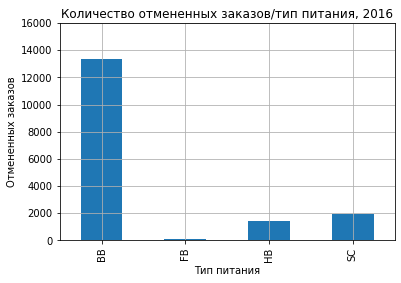

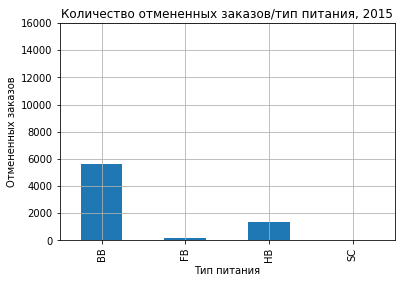

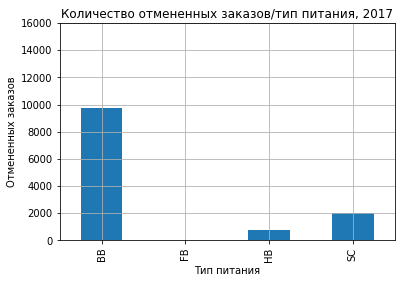

In [97]:
# строим гистограмму количества отмененных заказов и типов питания
plotly(hotel_train_2016,
       hotel_train_2015,
       hotel_test,
       'meal', 'Тип питания', 
       'Количество отмененных заказов/тип питания, 2016', 
       'Количество отмененных заказов/тип питания, 2015',
       'Количество отмененных заказов/тип питания, 2017')

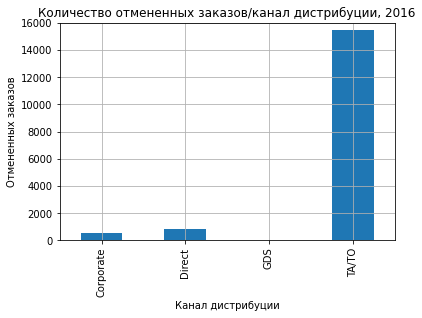

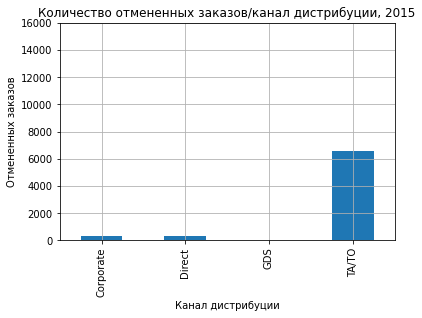

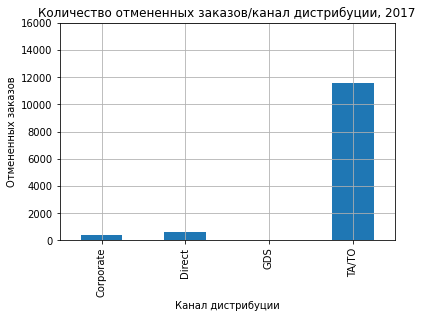

In [98]:
# строим гистограмму количества отмененных заказов и каналов дистрибуции
plotly(hotel_train_2016,
       hotel_train_2015,
       hotel_test,
       'distribution_channel', 'Канал дистрибуции', 
       'Количество отмененных заказов/канал дистрибуции, 2016', 
       'Количество отмененных заказов/канал дистрибуции, 2015',
       'Количество отмененных заказов/канал дистрибуции, 2017')

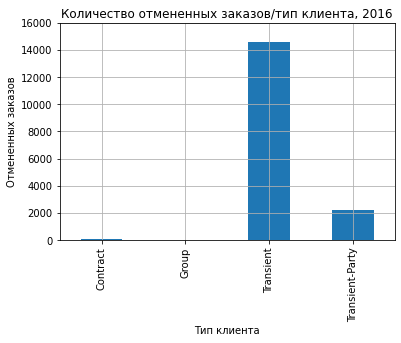

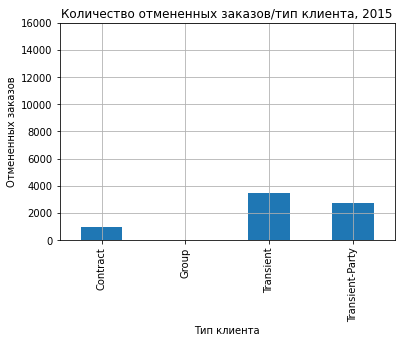

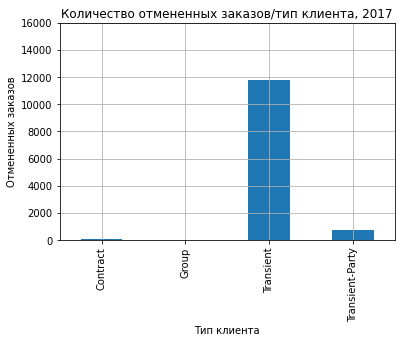

In [99]:
# строим гистограмму количества отмененных заказов и типов клиента 
plotly(hotel_train_2016,
       hotel_train_2015,
       hotel_test,
       'customer_type', 'Тип клиента', 
       'Количество отмененных заказов/тип клиента, 2016', 
       'Количество отмененных заказов/тип клиента, 2015',
       'Количество отмененных заказов/тип клиента, 2017')

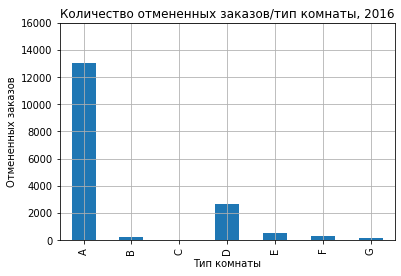

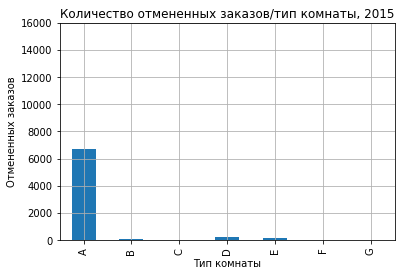

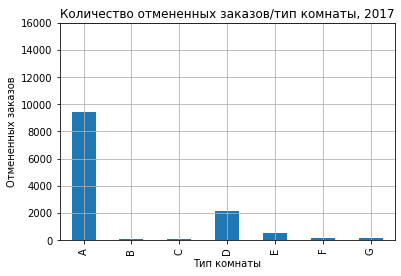

In [100]:
# строим гистограмму количества отмененных заказов и типов комнаты
plotly(hotel_train_2016,
       hotel_train_2015,
       hotel_test,
       'reserved_room_type', 'Тип комнаты', 
       'Количество отмененных заказов/тип комнаты, 2016', 
       'Количество отмененных заказов/тип комнаты, 2015',
       'Количество отмененных заказов/тип комнаты, 2017')

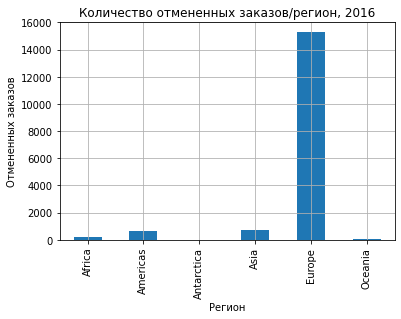

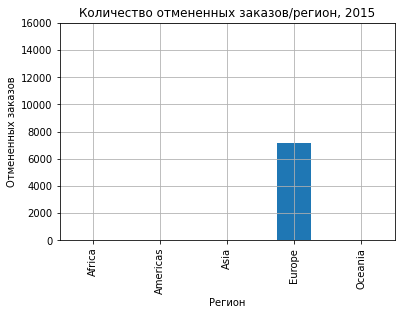

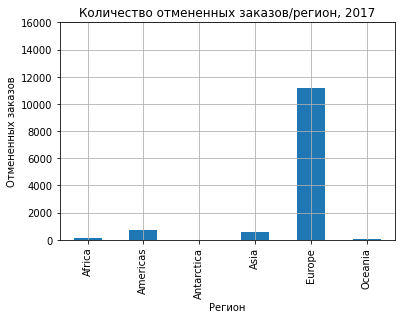

In [101]:
# строим гистограмму количества отмененных заказов и регионов 
plotly(hotel_train_2016,
       hotel_train_2015,
       hotel_test,
       'region', 'Регион', 
       'Количество отмененных заказов/регион, 2016', 
       'Количество отмененных заказов/регион, 2015',
       'Количество отмененных заказов/регион, 2017')

In [102]:
# формируем примерный портрет клиента(ов), максимально склонного(ных) к отказу за 2015-2016гг              
for column in hotel_train.columns:    
    print(column,hotel_train.groupby(column)['is_canceled'].sum().idxmax())

is_canceled 1
lead_time 34.0
arrival_date_year 2016
arrival_date_month 10
arrival_date_week_number 42
arrival_date_day_of_month 17
stays_in_weekend_nights 0
stays_in_week_nights 2
adults 2.0
children 0.0
babies 0.0
meal BB
distribution_channel TA/TO
is_repeated_guest 0
previous_cancellations 0
previous_bookings_not_canceled 0
reserved_room_type A
booking_changes 0
days_in_waiting_list 0
customer_type Transient
required_car_parking_spaces 0
total_of_special_requests 0
total_nights 2
region Europe


In [103]:
# формируем примерный портрет клиента(ов), максимально склонного(ных) к отказу за 2017гг     
for column in hotel_test.columns:    
    print(column,hotel_test.groupby(column)['is_canceled'].sum().idxmax())

is_canceled 1
lead_time 56.0
arrival_date_year 2017
arrival_date_month 5
arrival_date_week_number 20
arrival_date_day_of_month 15
stays_in_weekend_nights 0
stays_in_week_nights 2
adults 2.0
children 0.0
babies 0.0
meal BB
distribution_channel TA/TO
is_repeated_guest 0
previous_cancellations 0
previous_bookings_not_canceled 0
reserved_room_type A
booking_changes 0
days_in_waiting_list 0
customer_type Transient
required_car_parking_spaces 0
total_of_special_requests 0
total_nights 3
region Europe


### Вывод по пятому шагу

   - Потенциальный гость, наиболее склонный к отказу от брони, как правило, из Европы, путешествует без детей, без автомобиля, чаще вдвоем, транзитом, по будням, больше предпочитая селиться в номере в номера категории "А", с включенным завтраком, на две ночи. Такой клиент чаще бронирует за 1-2 месяца, через агентства и туроператоров, чаще впервые, без изменений в заказе и специальных требований.  

## Общий вывод
   
   - В процессе работы над проектом, мы:
   
      - Загрузили и изучили данные, провели их предобработку и исследовательский анализ и описали клиента наиболее склонного к отказу от брони;
   
      - Вычислили бизнес-метрику, сформулировали бизнес-задачу и задачу для модели ML;

      - Разработали модель ML  с лучшими гиперпараметрами, проверили ее работу на тестовом наборе и оценили прибыль от ее внедрения.



   - **Резюме**: 
       
     - Лучше всего с поставленной задачей справилась сбалансированная **модель Дерева решений** с максимальной глубиной 2, количеством примеров для разделения 2 и минимальным количеством объектов на листе 1. Модель показала на тестовой выборке значение метрики Recall - 68%, это значит, что модель правильно предсказала снятие брони клиентом в 2/3 случаев. Точнее, из 12.5 тыс. нужных правильных ответов (со значением 1) она предсказал 8,5 тыс.. 
     
     - **Внедрение модели** (на примере 2017 года) с не меньшим уровнем предсказаний **может принести** сети отелей **прибыль 15.763 млн. руб. в год**.     
